# Overview

What separates Hall of Fame baseball players from the rest? In particular, I was curious about what features separate Hall of Fame players versus the ones who were nominated but inducted. 

In other words, what separates the Hall of Fame from the Hall of Very Good?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from IPython.display import display

%matplotlib inline
pd.set_option('display.max_columns', None)

We use the Hall of Fame dataset to see who was inducted or not and merge with the Master set so we can see the players names.

# Data Wrangling
* Merge in Master to get names
* Merge in Award stats
* Merge in Appearances
* Merge in Pitching stats
* Merge in Batting stats
* Merge in Fielding stats

## Master

In [5]:
hof_df = pd.read_csv('baseballdatabank-master/core/HallOfFame.csv')
master_df = pd.read_csv('baseballdatabank-master/core/Master.csv', parse_dates=['debut', 'finalGame'])

hof_cols = ['playerID', 'nameFirst', 'nameLast'] + list(hof_df.columns[1:]) 

hof_df = hof_df.merge(master_df, on='playerID')
hof_df = hof_df[hof_cols]

hof_df.head()

,playerID,nameFirst,nameLast,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,Ty,Cobb,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,Babe,Ruth,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,Honus,Wagner,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,wagneho01,Honus,Wagner,1936,Veterans,78.0,59.0,5.0,N,Player,NaN
4,mathech01,Christy,Mathewson,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN


Since each row in the Hall of Fame set reflects a voting record, we group by playerID to remove duplicate rows. We end up with a single data frame of players, where the `inducted` field marks whether or not they are in the Hall of Fame.

There are 247 inducted players and 941 non-inducted players in this dataset.

In [3]:
player_votes = hof_df.loc[(hof_df.category == 'Player')]
inducted_players = hof_df.loc[(hof_df.inducted == 'Y') & (hof_df.category == 'Player')]

non_inducted_ids = set(player_votes.playerID).difference(inducted_players.playerID)

non_inducted_players = player_votes.loc[hof_df.playerID.isin(non_inducted_ids)]
non_inducted_players = non_inducted_players.groupby('playerID', as_index=False).last()

print("# of Inducted Players: %d" % inducted_players.shape[0])
print("# of Non-Inducted Players: %d" % non_inducted_players.shape[0])

nominated_players = inducted_players.append(non_inducted_players, ignore_index=True)
display(nominated_players.shape)

# of Inducted Players: 247
# of Non-Inducted Players: 941


(1188, 11)

## Awards
We add in Awards players won over the course of their career. It seems plausible that awards would be correlated with entrance into the Hall.

In [4]:
awards = pd.read_csv("baseballdatabank-master/core/AwardsPlayers.csv")

award_count = awards.groupby('playerID').size().reset_index()
award_count.columns = ['playerID', 'Awards']

# Convert each award into a column, value will be the count.
award_columns = awards[['playerID', 'awardID']].pivot_table(index='playerID', columns='awardID', 
                                                            aggfunc=np.count_nonzero, fill_value=0)

nominated_players = pd.merge(nominated_players, award_columns.reset_index(), on='playerID', how='left')
nominated_players = pd.merge(nominated_players, award_count, on='playerID', how='left')

# Not all players will get awards, so fill missing values with 0. 
# Note: needed_note field will also get replaced, but I don't use this field, so it's okay.
nominated_players.fillna(0, inplace=True)

nominated_players.head()

,playerID,nameFirst,nameLast,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards
0,cobbty01,Ty,Cobb,1936,BBWAA,226.0,170.0,222.0,Y,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0
1,ruthba01,Babe,Ruth,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
2,wagneho01,Honus,Wagner,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
3,mathech01,Christy,Mathewson,1936,BBWAA,226.0,170.0,205.0,Y,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,johnswa01,Walter,Johnson,1936,BBWAA,226.0,170.0,189.0,Y,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0


By looking at summary statistics and histograms, it seems like the average inducted player receives more awards than non-inducted players.

In [6]:
display(nominated_players[nominated_players.inducted == 'Y'].Awards.describe())
display(nominated_players[nominated_players.inducted == 'N'].Awards.describe())

count    247.000000
mean       9.210526
std        9.297489
min        0.000000
25%        1.000000
50%        7.000000
75%       14.000000
max       39.000000
Name: Awards, dtype: float64

count    941.000000
mean       2.380446
std        3.611713
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       47.000000
Name: Awards, dtype: float64

In [7]:
def plot_awards(df, title, bins=10):
    ax = df['Awards'].hist(bins=bins)
    ax.set_xlabel("Number of Awards")
    ax.set_ylabel("Count")
    ax.set_title(title)

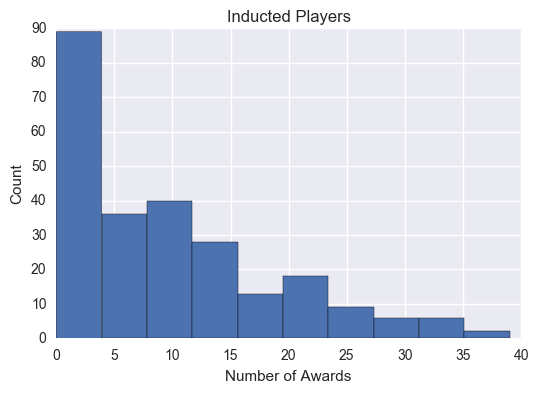

In [8]:
plot_awards(nominated_players[nominated_players.inducted == 'Y'], 'Inducted Players')

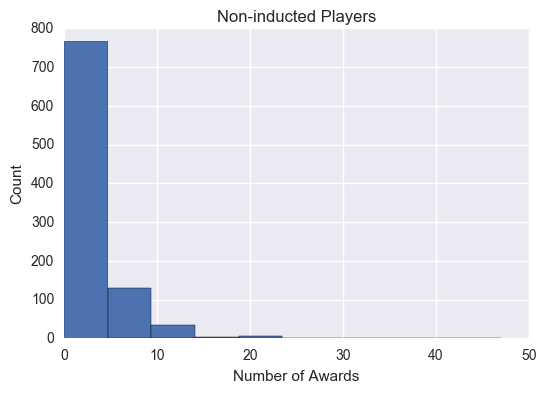

In [9]:
plot_awards(nominated_players[nominated_players.inducted == 'N'], 'Non-inducted Players')

# Appearances
Number of games played could approximate longevity.

In [10]:
def cumulative_stats(csv_path, display_head=True, agg_dict=None):
    df = pd.read_csv(csv_path)
    
    if display_head == True:
        display(df.head())
    
    df_total = None
    
    if agg_dict is None:
        df_total = df.groupby('playerID', as_index=False).sum()
        del df_total['yearID']
    else:
        df_total = df.groupby('playerID', as_index=False).agg(agg_dict)
    
    return df_total

# Merge with Appearances
appearances_total = cumulative_stats("baseballdatabank-master/core/Appearances.csv")

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1871,BS1,NaN,barnero01,31.0,NaN,31,31.0,0,0,0,16,0,15,0,0,0,0,NaN,NaN,NaN
1,1871,BS1,NaN,barrofr01,18.0,NaN,18,18.0,0,0,0,1,0,0,13,0,4,17,NaN,NaN,NaN
2,1871,BS1,NaN,birdsda01,29.0,NaN,29,29.0,0,7,0,0,0,0,0,0,27,27,NaN,NaN,NaN
3,1871,BS1,NaN,conefr01,19.0,NaN,19,19.0,0,0,0,0,0,0,18,0,1,18,NaN,NaN,NaN
4,1871,BS1,NaN,gouldch01,31.0,NaN,31,31.0,0,0,30,0,0,0,0,0,1,1,NaN,NaN,NaN


We also use the appearances data to determine the player's most played position.

In [ ]:
nominated_players = pd.merge(nominated_players, appearances_total, on='playerID')

position_cols = ['G_p','G_c','G_1b','G_2b',
                 'G_3b','G_ss','G_lf','G_cf',
                 'G_rf','G_of','G_dh','G_ph','G_pr']

def most_played_position(df):
    return df[position_cols].idxmax(axis=1).str.split('_').str[1].str.upper()

nominated_players.insert(3, 'Position', most_played_position(nominated_players))
display(nominated_players.head())

In [ ]:
nominated_players.Position.value_counts()

In [ ]:
display(nominated_players.loc[nominated_players.inducted == 'Y', 'Position'].value_counts())
display(nominated_players.loc[nominated_players.inducted == 'N', 'Position'].value_counts())

In [ ]:
# Convert inducted Y/N to numeric for corrplot later
def convert_inducted_to_numeric(s):
    if s == 'Y':
        return 1
    else:
        return 0

nominated_players['inducted'] = nominated_players['inducted'].apply(convert_inducted_to_numeric)

In [ ]:
agg_dict = {'ERA': np.mean, 'W': np.sum}
pitching_total = cumulative_stats("baseballdatabank-master/core/Pitching.csv", 
                                  display_head=False,
                                  agg_dict=agg_dict)

nominated_players = pd.merge(nominated_players, pitching_total, on='playerID', how='left')

In [ ]:
# adding in hitting stats

In [ ]:
def slugging_pct(df):
    return ((df['H'] - df['2B'] - df['3B'] - df['HR']) + 2*df['2B'] + 3*df['3B'] + 4*df['HR']) / df['AB']

def on_base_pct(df):
    return (df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['SF'] + df['HBP'])

def on_base_plus_slugging(df):
    return on_base_pct(df) + slugging_pct(df)

In [ ]:
batting_total = cumulative_stats("baseballdatabank-master/core/Batting.csv", 
                                  display_head=False)

nominated_players = pd.merge(nominated_players, batting_total, on='playerID', how='left')

# Pitching

I wanted to separate analysis between pitchers and non-pitchers. Let's start with pitchers.

In [ ]:
pitchers = nominated_players.loc[nominated_players.Position == 'P']

pitchers.head()

In [ ]:
def corr_plot(corr):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 7))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                square=True, xticklabels=corr.columns.values, 
                yticklabels=corr.columns.values,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

    ax.set_title("Correlation plot");

**Number of wins** seems to be most correlated with induction into the Hall of Fame, followed by **number of awards.**

In [ ]:
pitchers_corr = pitchers[['G_all', 'ERA', 'W', 'Cy Young Award', 'Awards', 'inducted']].corr()
pitchers_corr.columns = ['Games Played', 'ERA', 'Wins', 'Cy Young Award', 'Awards', 'Inducted']

display(pitchers_corr)
corr_plot(pitchers_corr)

# Non-Pitchers

For non-pitchers, I merged in hitting statistics and computed the common sabermetric statistics of on-base percentage (OBP), slugging percentage (SLG), and on-base plus slugging (OPS).

In [ ]:
# Merge with Batting
batting_total = cumulative_stats("baseballdatabank-master/core/Batting.csv", 
                                  display_head=False)
non_pitchers = nominated_players.loc[nominated_players.Position != 'P']
non_pitchers = pd.merge(non_pitchers, batting_total, on='playerID')

non_pitchers.fillna(0, inplace=True)

non_pitchers['BA'] = non_pitchers.H / non_pitchers.AB
non_pitchers['SLG'] = slugging_pct(non_pitchers)
non_pitchers['OBP'] = on_base_pct(non_pitchers)
non_pitchers['OPS'] = on_base_plus_slugging(non_pitchers)

non_pitchers.head()

The features most correlated with induction into the Hall of Fame are **Runs**, **Awards**, and **Hits.**

In [ ]:
def batting_corr_plot(df):
    corr = df[['G_all', 'R', 'RBI', 'HR', 'H', 'SB', 'SO', 'BA', 'SLG', 'OBP', 'OPS', 'Awards','inducted']].corr()
    corr.columns = ['Games Played', 'Runs', 'Runs Batted In', 'Home Runs', 
                        'Hits', 'Stolen Bases', 'Strike Outs', 'Batting Average', 
                        'On-base Percentage', 'Slugging Average', 'On-base Plus Slugging', 'Awards',
                        'Inducted']
    display(corr)
    corr_plot(corr)
    
    return corr

In [ ]:
# batting_corr = non_pitchers[['G_all', 'R', 'RBI', 'HR', 'H', 'SB', 'SO', 'BA', 'SLG', 'OBP', 'OPS', 'Awards','inducted']].corr()
# batting_corr.columns = ['Games Played', 'Runs', 'Runs Batted In', 'Home Runs', 
#                         'Hits', 'Stolen Bases', 'Strike Outs', 'Batting Average', 
#                         'On-base Percentage', 'Slugging Average', 'On-base Plus Slugging', 'Awards',
#                         'Inducted']
# display(batting_corr)
# corr_plot(batting_corr)

_ = batting_corr_plot(non_pitchers)

In [ ]:
non_pitchers = pd.merge(non_pitchers, master_df[['playerID', 'finalGame']], on='playerID')


In [ ]:
non_pitchers['Final Year'] = pd.DatetimeIndex(non_pitchers['finalGame']).year
sum((non_pitchers['Final Year'] - 1994) >= 5)

In [ ]:
non_steroids_era = non_pitchers.loc[non_pitchers['Final Year'] - 1994 < 5]
steroids_era = non_pitchers.loc[non_pitchers['Final Year'] - 1994 >= 5]

display(non_steroids_era.shape)
display(steroids_era.shape)

In [ ]:
non_steroids_corr = batting_corr_plot(non_steroids_era)

In [ ]:
steroids_corr = batting_corr_plot(steroids_era)

In [ ]:
steroids_corr['Inducted'] - non_steroids_corr['Inducted']

# Hitting Correlations by Position
Do they vary by position?

In [ ]:
non_pitchers.Position.unique()

In [ ]:
positions = ['OF', 'SS', '2B', 'C', '1B', '3B', 'DH', 'PH']

for pos in positions:
    print(pos)
    print(non_pitchers.loc[non_pitchers.Position == pos].shape)
    batting_corr_plot(non_pitchers.loc[non_pitchers.Position == pos])

# Conclusion
For pitchers, cumulative statistics such as wins and number of awards were most correlated with induction into the Hall of Fame. 
For non-pitchers, runs scored, hits, and awards were the most highly correlated with induction.

There are other directions I'd like to go in with this analysis:

* Add more player data, including fielding statistics. 
* Compare players voted in by different methods. Are there differences between players voted in via the Baseball Writers vs. the Veterans Committee?
* Compare players from different eras. The modern game is dominated by newer metrics of player performance. Have voters opinions changed as a result of this?